In [1]:
# Install dependencies
# !pip install -q transformers==4.17
# !pip install tensorflow-macos 
# !pip install tensorflow-metal
# !pip install tensorflow==2.15.0 --quiet
# !pip install tensorflow-text==2.15.0 --quiet
# !pip install tensorflow-privacy
# !pip install numpy==1.26.4
# !pip install pandas==2.1.1


In [2]:
import os
import warnings
import logging

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Suppress warnings from all Python libraries
warnings.filterwarnings('ignore')

# Configure basic logging level
logging.basicConfig(level=logging.ERROR)

# Target specific libraries
for module in ['tensorflow', 'absl', 'transformers', 'tensorboard']:
    logging.getLogger(module).setLevel(logging.ERROR)

from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

# Suppress the specific BERT layer warnings
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.15.0
Num GPUs Available: 1


In [4]:
# import libraries/modules

import pandas as pd
import numpy as np
import gc
import time

import tensorflow as tf
import tensorflow_privacy
from tensorflow_privacy.privacy.optimizers import dp_optimizer_keras
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel, BertTokenizer, TFDistilBertModel, DistilBertTokenizer
from tensorflow_privacy.privacy.analysis import compute_noise_from_budget_lib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from mia_callback import MembershipInferenceCallback

In [5]:
print(f" Tensorflow_privacy version: {tensorflow_privacy.__version__}")

 Tensorflow_privacy version: 0.9.0


In [6]:
MAX_LENGTH = 512
EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 3

In [7]:
# load dataset
reviews_df = pd.read_pickle('data/resto_reviews_3classes.pkl')

In [8]:
# shuffle dataframe
reviews_df = reviews_df.sample(frac=1, random_state=333)
# Reset index
reviews_df = reviews_df.reset_index(drop=True)

# Preview dataframe
display(reviews_df)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,-UT31RucmfbEGfivMkciZw,gbL42P8Z5xpe1sofOc2BSw,I2CxrvM0BGH1svfxqGGD2g,3.0,0,0,0,Meh. The burger was okay. Definitely not my fa...,2021-04-11 22:20:41,neutral
1,cM3mji0A120FfiKi5Ek-qA,Ff2GdWX5-dIBEshaDVFXZQ,xlMQBBt9wrtahdqiRDcVSg,4.0,0,0,0,Nice place with good pizzas. I had read on Yel...,2019-03-20 14:40:33,positive
2,GV8i7pTgvUeMjWz9bvxe4A,xc77WacvmbKHLCTonbncVQ,quk6TFDQyuQ4g0KuIb9qUA,5.0,0,0,0,Delicious hand tossed pizza. Just the right ba...,2018-03-26 22:46:11,positive
3,Q0BV4QVLzZGJ_9noP-h7gw,gTbszaM0-skT5ZMx5wbUwg,8wRT3Bt0LUtXeh1-dqTs0Q,1.0,0,0,0,They don't care how to treat a costumer. And a...,2021-04-27 14:02:43,negative
4,bYvOQx6UoQWFiLp6oYd-EA,rOwXHhjNH4HIBbuUtITYKw,PlaECqs3oPBRo47p85zkzw,2.0,0,0,1,We took our sister here for her going away par...,2016-03-05 02:56:06,negative
...,...,...,...,...,...,...,...,...,...,...
5995,eK63-fNL2NINRw0Dm5ANrw,JiSeEUEu-af8Z-mQqoX-Vg,Jzb2IQSwPfULWzdl9Bq5fg,2.0,1,0,0,Know full well that if you do not go in there ...,2015-07-23 00:55:21,negative
5996,boExHQYf14LpM2NWgwYHlA,gwKmQrMDjpPuLa2gXc87tw,SYL6bNTsT9P7iNt3A1Cwqw,2.0,0,0,0,Service bad. Staff was loud in professional an...,2018-09-02 18:36:11,negative
5997,rPmbWN4HAZNJYE33v5pY2A,8rVXQ3p6Tiyq1FS4iVMVcA,dNmqRPHBys4dWH4nReO7MA,3.0,1,0,0,I would not recommend this place for most thin...,2014-02-25 00:28:42,neutral
5998,OiDy2R20zvDtMvLo4auFiQ,lPkP_TNt_4sNBAKHvSgx8w,LF8UjsBRaQ4Aqwu3ARxnBg,2.0,2,1,2,"After many many trips to Rodizio, this past tr...",2019-12-19 16:14:11,negative


In [9]:
# Label encode forms
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the column
reviews_df['sentiment_encoded'] = le.fit_transform(reviews_df['sentiment'])

# Calculate the desired training set size (nearest multiple of 32 to 60% of data)
# This is so batch sizes can be divided evenly for DP microbatches
total_samples = len(reviews_df)
train_size = int(total_samples * 0.6)
train_size_adjusted = (train_size // 32) * 32  # Round down to nearest multiple of 32

# Use the adjusted size in train_test_split
train_ratio = train_size_adjusted / total_samples
remaining_ratio = 1 - train_ratio

x_train, x_temp, y_train, y_temp = train_test_split(reviews_df['text'], reviews_df['sentiment_encoded'], test_size=remaining_ratio, random_state=123, stratify=reviews_df['sentiment_encoded'])
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=1234,
    stratify=y_temp)

# lowercase text if using uncased pretrained model
x_train = x_train.str.lower()
x_val = x_val.str.lower()
x_test = x_test.str.lower()

# Calculate delta
n_examples = len(x_train)
DELTA = round(1/n_examples, 5)


In [10]:
# Create bert encoder function
def bert_encode(texts, tokenizer, max_len=MAX_LENGTH):
    # Convert texts to strings
    texts_str = [str(text) for text in texts]

    # Tokenize texts
    tokenized = tokenizer(texts_str,
                         max_length=max_len,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')

    return tokenized


# select tokenizer
def select_tokenizer(pretrained):
    # Extract model type from checkpoint name
    if 'distilbert' in pretrained.lower():
        return DistilBertTokenizer.from_pretrained(pretrained)
    elif 'bert' in pretrained.lower():
        return BertTokenizer.from_pretrained(pretrained)
    else:
        raise ValueError(f"Unsupported model type: {pretrained}")

# Confusion matrix display function
def plot_confusion_matrix(cm, class_names=['Negative', 'Neutral', 'Positive']):
    plt.figure(figsize=(8, 6))

    # Create heatmap with numerical values inside cells
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    # Add labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Add accuracy in each cell as percentage
    total = np.sum(cm)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j + 0.5, i + 0.7, f'({cm[i, j]/total*100:.1f}%)',
                    ha='center', color='black' if cm[i, j] < cm.max()/2 else 'white')

    plt.tight_layout()
    return plt

In [11]:
# Select pretrained
model_checkpoint = 'distilbert-base-uncased'

# Load tokenizer
bert_tokenizer = select_tokenizer(model_checkpoint)
print(f"Using {type(bert_tokenizer).__name__} with {model_checkpoint}")

# Tokenize dataset
train_encodings = bert_encode(x_train, bert_tokenizer)
val_encodings = bert_encode(x_val, bert_tokenizer)
test_encodings = bert_encode(x_test, bert_tokenizer)
train_labels = tf.convert_to_tensor(y_train, dtype=tf.int32)
val_labels = tf.convert_to_tensor(y_val, dtype=tf.int32)
test_labels = tf.convert_to_tensor(y_test, dtype=tf.int32)

Using DistilBertTokenizer with distilbert-base-uncased


In [12]:
print("Type of train_encodings:", type(train_encodings))
print("Keys of train_encodings:", train_encodings.keys())
print("train_y shape:", train_labels.shape)
print("train_y dtype:", train_labels.dtype)
print("train_y unique values:", np.unique(train_labels))
print("Number of classes:", len(np.unique(train_labels)))

Type of train_encodings: <class 'transformers.tokenization_utils_base.BatchEncoding'>
Keys of train_encodings: dict_keys(['input_ids', 'attention_mask'])
train_y shape: (3584,)
train_y dtype: <dtype: 'int32'>
train_y unique values: [0 1 2]
Number of classes: 3


## Model with Differential Privacy Integration

In [13]:
def build_dp_model(bert_base,
                trainable=True,
                max_length=MAX_LENGTH,
                num_classes=NUM_CLASSES,
                hidden_sizes=[128],
                #dropout=[0.3], # Removed to increase overfitting
                learning_rate=0.0001,
                epsilon=None,
                delta=DELTA,
                l2_norm_clip=1.0,
                num_microbatches=1):

    # Select appropriate model type based on the checkpoint name
    if 'distilbert' in bert_base:
        bert_model = TFDistilBertModel.from_pretrained(bert_base)
    else:
        bert_model = TFBertModel.from_pretrained(bert_base)

    # Unfreeze all layers to make model overfit
    # Overfitting provides more evidence that DP is working (less memorization)
    bert_model.trainable = trainable  # This sets everything trainable
    
    # Unfreeze only final layers to save on compute
    if 'distilbert' in bert_base:
        for i in range(0, len(bert_model.distilbert.transformer.layer) - 4):
            bert_model.distilbert.transformer.layer[i].trainable = False  
    else:
        for i in range(0, len(bert_model.encoder.layer) - 4):
            bert_model.encoder.layer[i].trainable = False  

    # Create input layers
    input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    if 'distilbert' in bert_base:
        bert_inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
        model_inputs = [input_ids, attention_mask]
    else:
        token_type_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
        bert_inputs = {
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask
        }
        model_inputs = [input_ids, token_type_ids, attention_mask]

    bert_output = bert_model(bert_inputs)

    # Get pooler output
    if 'distilbert' in bert_base:
        sequence_output = bert_output[0]
        pooler_output = sequence_output[:, 0, :]
    else:
        pooler_output = bert_output[1]

    # Add multiple hidden layers with decreasing sizes
    hidden = pooler_output
    for i, hidden_size in enumerate(hidden_sizes):
        hidden = tf.keras.layers.Dense(hidden_size, activation='relu')(hidden)
        # if i < 1:
        #     hidden = tf.keras.layers.Dropout(dropout[i], name=f'dropout_{i}')(hidden)

    class_output = tf.keras.layers.Dense(num_classes, activation=None, name="classification_layer")(hidden)

    model = tf.keras.Model(inputs=model_inputs, outputs=class_output)
    
    
    if epsilon is not None:
        # Calculate noise multiplier
        noise = compute_noise_from_budget_lib.compute_noise(n_examples,
                                                            BATCH_SIZE,
                                                            epsilon,
                                                            EPOCHS,
                                                            delta,
                                                            0.1)

        optimizer = dp_optimizer_keras.DPKerasAdamOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate)

        # For DP: Use non-reduced sparse categorical loss (calculates loss for each data point)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)


    else:
        # Standard optimizer (no privacy)
        optimizer = Adam(learning_rate=learning_rate)
        # For non-DP: Use standard reduced loss
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        print("No privacy protection applied")

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'])

    return model

# Obtain instance of pretrained model
dp_model = build_dp_model(model_checkpoint)
dp_model.summary()



No privacy protection applied
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['attention_mask_layer[0][0]',
 stilBertModel)              den_state=(None, 512, 768)   0     

In [14]:
tf.keras.backend.clear_session()
gc.collect()
# Short delay to ensure cleanup completes
time.sleep(1)

## Experiments


In [15]:
def run_dp_hyperparameter_study(train_x, train_y, val_x, val_y, test_x, test_y, selected_model, ablation_epochs=1):

    results = []

    # Prepare inputs based on model type
    if 'distilbert' in model_checkpoint:
        train_inputs = [train_x.input_ids, train_x.attention_mask]
        val_inputs = [val_x.input_ids, val_x.attention_mask]
        test_inputs = [test_x.input_ids, test_x.attention_mask]
    else:
        train_inputs = [train_x.input_ids, train_x.token_type_ids, train_x.attention_mask]
        val_inputs = [val_x.input_ids, val_x.token_type_ids, val_x.attention_mask]
        test_inputs = [test_x.input_ids, test_x.token_type_ids, test_x.attention_mask]


    # Clipping norm study
    print("\n" + "="*50)
    print("Pick clipping norm")
    print("="*50)

    clip_norms = [0.3, 0.5, 1.0, 1.5]
    for clip_norm in clip_norms:
        print(f"\nTesting clipping norm: {clip_norm}")

        # Use a fixed epsilon and microbatches for this test
        epsilon = 1.0
        microbatches = 1

       # Build model with specified privacy budget
        model = build_dp_model(
            selected_model,
            epsilon=epsilon,
            l2_norm_clip=clip_norm,
            num_microbatches=microbatches
        )
        
        
        # Train model
        history = model.fit(
            train_inputs,
            train_y,
            validation_data=(val_inputs, val_y),
            batch_size=BATCH_SIZE,
            epochs=ablation_epochs,
            verbose=1
        )
        
        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_inputs, test_y, verbose=0)

        # Get predictions and calculate F1 score
        y_pred = np.argmax(model.predict(test_inputs), axis=1)
        f1 = f1_score(test_y, y_pred, average='weighted')

        print(f"Results for clip_norm={clip_norm}:")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"F1 Score: {f1:.4f}")

        results.append({
            'parameter': 'clip_norm',
            'value': clip_norm,
            'epsilon': epsilon,
            'microbatches': microbatches,
            'accuracy': test_acc,
            'f1_score': f1,
            'val_accuracy': max(history.history['val_accuracy'])})

        # cleanup
        tf.keras.backend.clear_session()
        gc.collect()
        # Short delay to ensure cleanup completes
        time.sleep(1)

    # Find best clip_norm
    best_clip_results = [r for r in results if r['parameter'] == 'clip_norm']
    best_clip_norm = max(best_clip_results, key=lambda x: x['f1_score'])['value']
    print(f"\nBest configuration:")
    print(f"- Clipping norm: {best_clip_norm}")

    # Create DataFrame from results
    results_df = pd.DataFrame(results)

    # Plot results
    plot_ablation_results(results_df)

    return results_df, best_clip_norm

def plot_ablation_results(results_df):
    plt.figure(figsize=(6, 5))

    # Plot clipping norm results
    clip_norm_results = results_df[results_df['parameter'] == 'clip_norm']
    plt.plot(clip_norm_results['value'], clip_norm_results['accuracy'], 'o-', label='Accuracy')
    plt.plot(clip_norm_results['value'], clip_norm_results['f1_score'], 'd-', label='F1 Score')
    plt.title('Effect of Clipping Norm (C) on Model Performance')
    plt.xlabel('Clipping Norm')
    plt.ylabel('Performance Metric')
    plt.grid(True)
    plt.legend()


    plt.tight_layout()
    plt.savefig('dp_hyperparameter_ablation.png', dpi=300)
    plt.show()


Pick clipping norm

Testing clipping norm: 0.3
DP-SGD with sampling rate = 0.893% and noise_multiplier = 1.2278736707584814 iterated over 1120 steps satisfies differential privacy with eps = 1 and delta = 0.00028.
Epoch 1/5
112/112 [==============================] - 162s 1s/step - loss: 1.1134 - accuracy: 0.3555 - val_loss: 1.0961 - val_accuracy: 0.3452
Epoch 2/5
112/112 [==============================] - 161s 1s/step - loss: 1.1121 - accuracy: 0.3504 - val_loss: 1.0926 - val_accuracy: 0.3460
Epoch 3/5
112/112 [==============================] - 203s 2s/step - loss: 1.1084 - accuracy: 0.3672 - val_loss: 1.0866 - val_accuracy: 0.3651
Epoch 4/5
112/112 [==============================] - 186s 2s/step - loss: 1.1046 - accuracy: 0.3655 - val_loss: 1.0834 - val_accuracy: 0.3717
Epoch 5/5
38/38 [==============================] - 20s 494ms/step
Results for clip_norm=0.3:
Accuracy: 0.3783
F1 Score: 0.3620

Testing clipping norm: 0.5
DP-SGD with sampling rate = 0.893% and noise_multiplier = 1.22

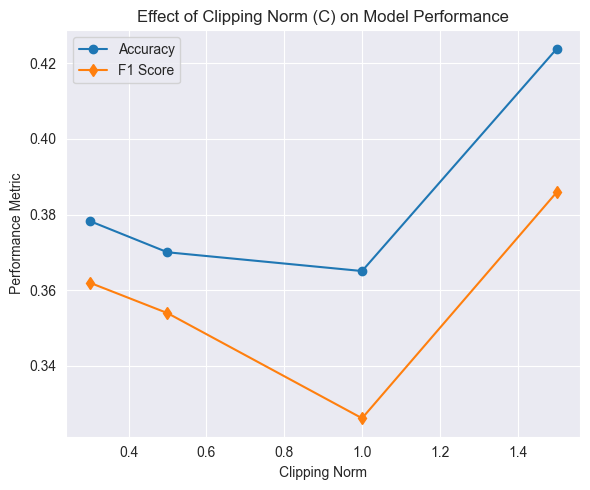

,parameter,value,epsilon,microbatches,accuracy,f1_score,val_accuracy
0,clip_norm,0.3,1.0,1,0.378311,0.361995,0.383278
1,clip_norm,0.5,1.0,1,0.370033,0.353936,0.351821
2,clip_norm,1.0,1.0,1,0.365066,0.326120,0.365894
3,clip_norm,1.5,1.0,1,0.423841,0.385892,0.399834


- Best clipping norm: 1.5


In [16]:
# Run the simplified hyperparameter ablation study
clipnorm_results_df, best_clip_norm = run_dp_hyperparameter_study(
    train_encodings, train_labels,
    val_encodings, val_labels,
    test_encodings, test_labels,
    model_checkpoint,
    ablation_epochs=EPOCHS//2
)

# Display summary table
display(clipnorm_results_df)

print(f"- Best clipping norm: {best_clip_norm}")

In [17]:
# Run experiments with different privacy budgets
def run_dp_experiments(train_x, train_y, val_x, val_y, test_x, test_y, epsilons=[None], set_microbatch=1, clip_norm=0.5):
    results = []
    # Set up inputs based on model type
    if 'distilbert' in model_checkpoint:
        train_inputs = [train_x.input_ids, train_x.attention_mask]
        val_inputs = [val_x.input_ids, val_x.attention_mask]
        test_inputs = [test_x.input_ids, test_x.attention_mask]
    else:
        train_inputs = [train_x.input_ids, train_x.token_type_ids, train_x.attention_mask]
        val_inputs = [val_x.input_ids, val_x.token_type_ids, val_x.attention_mask]
        test_inputs = [test_x.input_ids, test_x.token_type_ids, test_x.attention_mask]


    for epsilon in epsilons:
        print(f"\n{'=' * 50}")
        print(f"Training with epsilon = {epsilon if epsilon is not None else 'No DP'}")
        print(f"{'=' * 50}")

        # Build model with specified privacy budget
        model = build_dp_model(
            model_checkpoint,
            epsilon=epsilon,
            l2_norm_clip=clip_norm,
            num_microbatches=set_microbatch
        )
        
        # Create instance of model inference attack callback
        mia_callback = MembershipInferenceCallback(
            train_inputs=train_inputs,
            train_labels=train_y,
            val_inputs=val_inputs,
            val_labels=val_y,
            run_epochs=[1, 5, 10])
        
        
        # Train model
        history = model.fit(
            train_inputs,
            train_y,
            validation_data=(val_inputs, val_y),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[mia_callback],
            verbose=1
        )

        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_inputs, test_y, verbose=0)

        # Get predictions and calculate F1 score
        y_pred = np.argmax(model.predict(test_inputs), axis=1)
        f1 = f1_score(test_y, y_pred, average='weighted')

        # Generate confusion matrix
        cm = confusion_matrix(test_y, y_pred)

        # Store results
        results.append({
            'epsilon': epsilon,
            'accuracy': test_acc,
            'f1_score': f1,
            'val_accuracy': max(history.history['val_accuracy']),
            'training_history': history.history,
            'mia_results': mia_callback.attack_results,
            'mia_predictions': mia_callback.epoch_predictions,
            'epoch_f1_scores': mia_callback.f1_per_epoch, 
        })

        print(f"Test results for epsilon={epsilon if epsilon is not None else 'No DP'}:")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Show confusion matrix
        plot_confusion_matrix(cm)
        plt.show()
        
        # cleanup
        tf.keras.backend.clear_session()
        gc.collect()
        # Short delay to ensure cleanup completes
        time.sleep(1)

    return results

# Plot results to visualize privacy-utility tradeoff
def plot_privacy_utility_tradeoff(results):
    # Convert None to "No DP" for plotting
    epsilon_labels = ["No DP" if r['epsilon'] is None else str(r['epsilon']) for r in results]
    accuracies = [r['accuracy'] for r in results]
    f1_scores = [r['f1_score'] for r in results]

    plt.figure(figsize=(12, 8))

    # Plot privacy-utility tradeoff
    plt.subplot(2, 1, 1)
    plt.plot(epsilon_labels, accuracies, 'o-', label='Accuracy')
    plt.plot(epsilon_labels, f1_scores, 'd-', label='F1 Score')
    plt.title('Model Performance for Each Epsilon')
    plt.xlabel('Privacy Budget (ε)')
    plt.ylabel('Performance Metric')
    plt.grid(True)
    plt.legend()

    # Plot training curves for each epsilon
    plt.subplot(2, 1, 2)
    for i, r in enumerate(results):
        if 'training_history' in r and 'val_accuracy' in r['training_history']:
            val_acc = r['training_history']['val_accuracy']
            if isinstance(val_acc, list) and len(val_acc) > 0:
                # Get x values (epochs)
                epochs = list(range(1, len(val_acc) + 1))
                label = f"ε={r['epsilon']}" if r['epsilon'] is not None else "No DP"
                plt.plot(epochs, val_acc, marker='o', label=label)

    plt.title('Validation Accuracy During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.xticks(np.arange(1, EPOCHS+1))
    plt.ylim(0, 1.0)  # Accuracy is between 0 and 1
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('privacy_utility_tradeoff.png', dpi=300)
    plt.show()

    # Create a summary table of performance metrics
    performance_df = pd.DataFrame({
        'Epsilon': ['No DP' if r['epsilon'] is None else f"ε={r['epsilon']}" for r in results],
        'Accuracy': [r['accuracy'] for r in results],
        'F1 Score': [r['f1_score'] for r in results],
        'Best Val Accuracy': [r['val_accuracy'] for r in results]
    })
    
    mia_rows = []
    for r in results:
        epsilon_label = 'No DP' if r['epsilon'] is None else f"ε={r['epsilon']}"
        for epoch_result in r['mia_results']:
            epoch = epoch_result[0]
            metrics = epoch_result[1]
            mia_rows.append({
                'Epsilon': epsilon_label,
                'Epoch': epoch,
                'MIA Accuracy': metrics.get('accuracy', None),
                'MIA AUC': metrics.get('auc', None),
                'Threshold': metrics.get('threshold', None),
                'Attack Type': metrics.get('attack_type', None),
            })

    mia_df = pd.DataFrame(mia_rows)
    

    return performance_df, mia_df


def get_mia_metric(r, epoch, metric):
    if 'mia_results' in r:
        for ep, res in r['mia_results']:
            if ep == epoch:
                return res.get(metric, np.nan)
    return np.nan


def plot_mia_results(results):
    plt.figure(figsize=(14, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    for r in results:
        if 'mia_results' not in r:
            continue
        eps_label = 'No DP' if r['epsilon'] is None else f"ε={r['epsilon']}"
        epochs = [epoch for epoch, _ in r['mia_results']]
        accs = [metrics['accuracy'] for _, metrics in r['mia_results']]
        plt.plot(epochs, accs, label=eps_label, marker='o')
    plt.title("MIA Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend(title='Epsilon', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Subplot 2: AUC
    plt.subplot(1, 2, 2)
    for r in results:
        if 'mia_results' not in r:
            continue
        eps_label = 'No DP' if r['epsilon'] is None else f"ε={r['epsilon']}"
        epochs = [epoch for epoch, _ in r['mia_results']]
        aucs = [metrics['auc'] for _, metrics in r['mia_results']]
        plt.plot(epochs, aucs, label=eps_label, marker='o')
    plt.title("MIA AUC Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.grid(True)
    plt.legend(title='Epsilon', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()



Training with epsilon = No DP
No privacy protection applied
Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 0.7499 - accuracy: 0.6666
🔐 MIA (Epoch 1): Accuracy=0.7479, AUC=0.5199
112/112 [==============================] - 232s 2s/step - loss: 0.7499 - accuracy: 0.6666 - val_loss: 0.5090 - val_accuracy: 0.7699
Epoch 2/10
112/112 [==============================] - 317s 3s/step - loss: 0.4380 - accuracy: 0.8172 - val_loss: 0.5003 - val_accuracy: 0.7939
Epoch 3/10
112/112 [==============================] - 244s 2s/step - loss: 0.2697 - accuracy: 0.8959 - val_loss: 0.6004 - val_accuracy: 0.7790
Epoch 4/10
112/112 [==============================] - 254s 2s/step - loss: 0.1419 - accuracy: 0.9492 - val_loss: 0.7086 - val_accuracy: 0.7823
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9746
🔐 MIA (Epoch 5): Accuracy=0.7581, AUC=0.6328
112/112 [==============================] - 248s 2s/step - loss: 0.0791 - accuracy: 0.9746 - val_

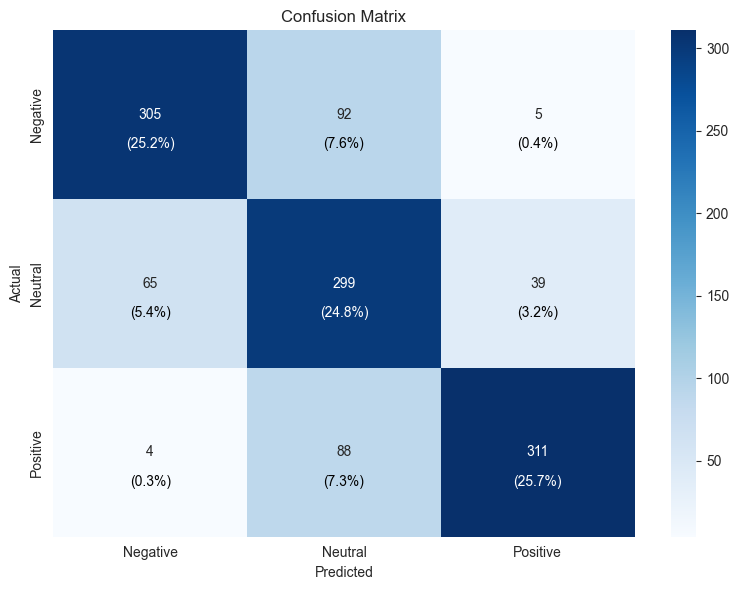


Training with epsilon = 10.0
DP-SGD with sampling rate = 0.893% and noise_multiplier = 0.5241908942128889 iterated over 1120 steps satisfies differential privacy with eps = 10 and delta = 0.00028.
Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 1.1306 - accuracy: 0.3669
🔐 MIA (Epoch 1): Accuracy=0.7479, AUC=0.4996
112/112 [==============================] - 272s 2s/step - loss: 1.1306 - accuracy: 0.3669 - val_loss: 1.0837 - val_accuracy: 0.3700
Epoch 2/10
112/112 [==============================] - 259s 2s/step - loss: 1.0784 - accuracy: 0.3945 - val_loss: 1.0526 - val_accuracy: 0.4189
Epoch 3/10
112/112 [==============================] - 259s 2s/step - loss: 1.0564 - accuracy: 0.4283 - val_loss: 1.0375 - val_accuracy: 0.4503
Epoch 4/10
112/112 [==============================] - 259s 2s/step - loss: 1.0462 - accuracy: 0.4436 - val_loss: 1.0271 - val_accuracy: 0.4685
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 1.0370 - accuracy: 0.4526
🔐 MI

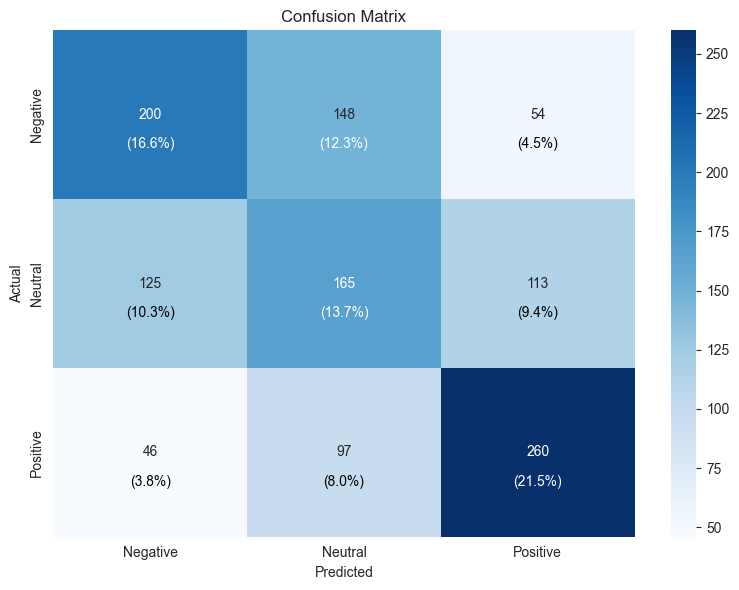


Training with epsilon = 1.0
DP-SGD with sampling rate = 0.893% and noise_multiplier = 1.2278736707584814 iterated over 1120 steps satisfies differential privacy with eps = 1 and delta = 0.00028.
Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 1.3878 - accuracy: 0.3340
🔐 MIA (Epoch 1): Accuracy=0.7481, AUC=0.5078
112/112 [==============================] - 269s 2s/step - loss: 1.3878 - accuracy: 0.3340 - val_loss: 1.3451 - val_accuracy: 0.3328
Epoch 2/10
112/112 [==============================] - 259s 2s/step - loss: 1.3232 - accuracy: 0.3331 - val_loss: 1.2961 - val_accuracy: 0.3344
Epoch 3/10
112/112 [==============================] - 259s 2s/step - loss: 1.2819 - accuracy: 0.3318 - val_loss: 1.2643 - val_accuracy: 0.3336
Epoch 4/10
112/112 [==============================] - 258s 2s/step - loss: 1.2544 - accuracy: 0.3334 - val_loss: 1.2261 - val_accuracy: 0.3344
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 1.2188 - accuracy: 0.3351
🔐 MIA 

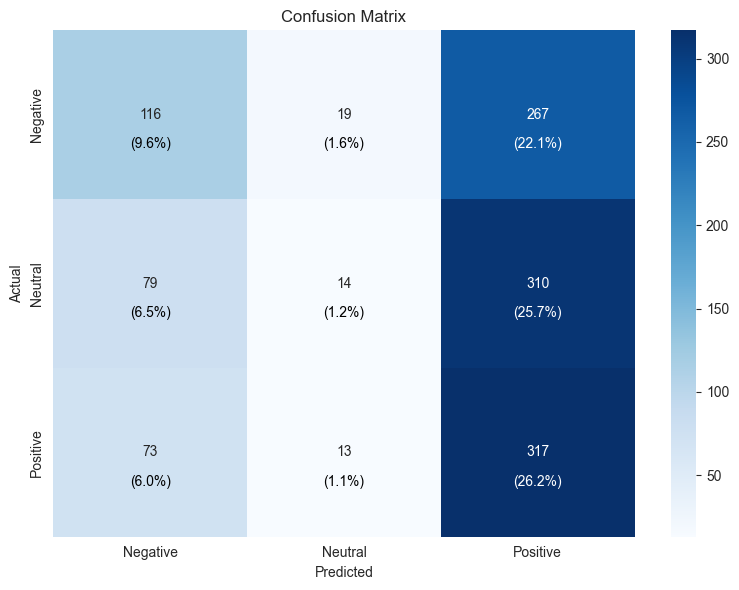


Training with epsilon = 0.1
DP-SGD with sampling rate = 0.893% and noise_multiplier = 7.504833231429233 iterated over 1120 steps satisfies differential privacy with eps = 0.1 and delta = 0.00028.
Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 1.1659 - accuracy: 0.3050
🔐 MIA (Epoch 1): Accuracy=0.7479, AUC=0.5053
112/112 [==============================] - 266s 2s/step - loss: 1.1659 - accuracy: 0.3050 - val_loss: 1.1470 - val_accuracy: 0.2897
Epoch 2/10
112/112 [==============================] - 258s 2s/step - loss: 1.1595 - accuracy: 0.3108 - val_loss: 1.1449 - val_accuracy: 0.2881
Epoch 3/10
112/112 [==============================] - 259s 2s/step - loss: 1.1587 - accuracy: 0.3145 - val_loss: 1.1451 - val_accuracy: 0.2947
Epoch 4/10
112/112 [==============================] - 258s 2s/step - loss: 1.1546 - accuracy: 0.3147 - val_loss: 1.1450 - val_accuracy: 0.2939
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 1.1578 - accuracy: 0.3122
🔐 MIA

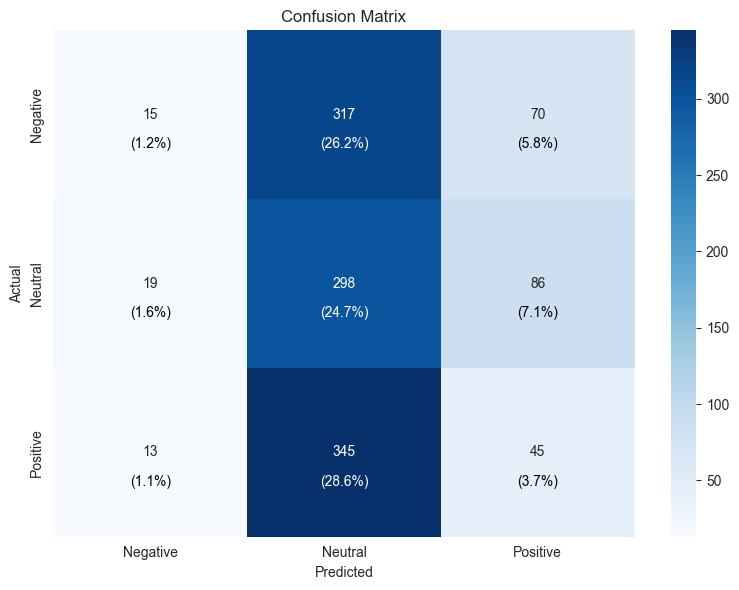

In [19]:
#Set privacy budgets to test
epsilon_values = [None, 10.0, 1.0, 0.1]

# Run the experiments
results = run_dp_experiments(train_encodings, train_labels, val_encodings, val_labels, test_encodings, test_labels, epsilons=epsilon_values, set_microbatch=1, clip_norm=best_clip_norm)

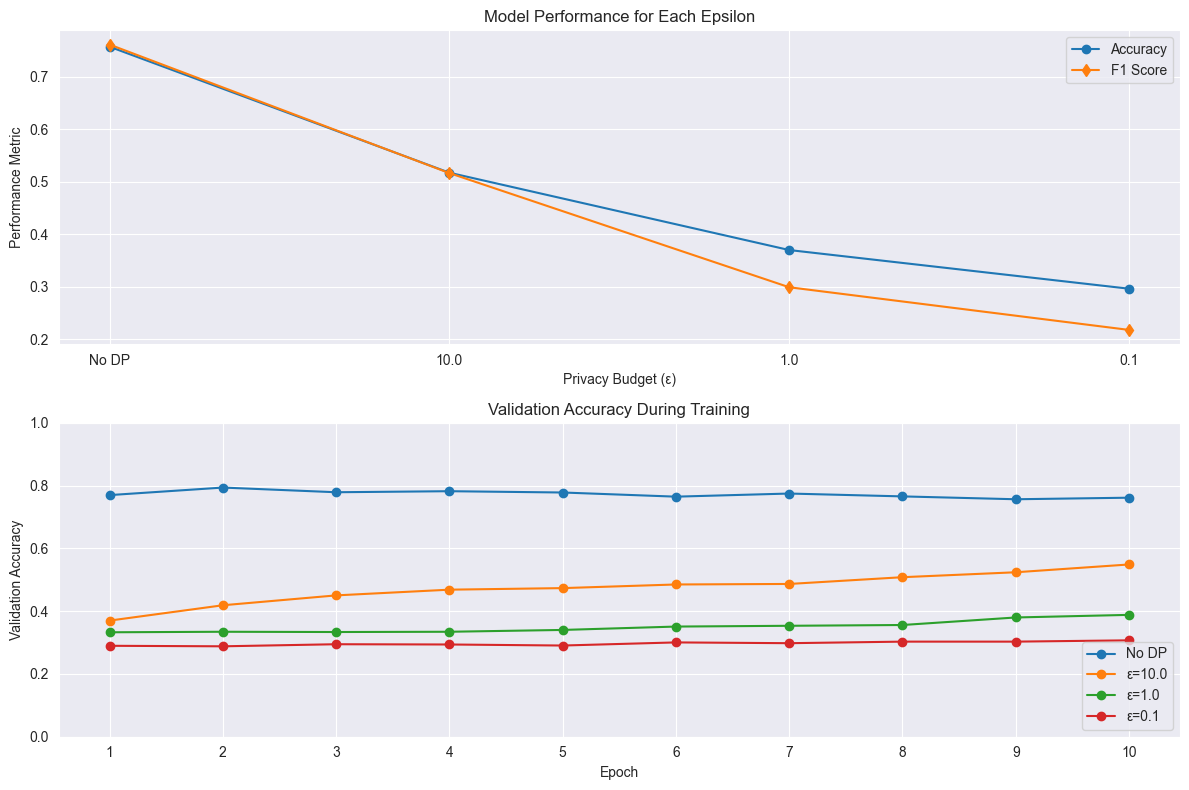

Performance Summary:


,Epsilon,Accuracy,F1 Score,Best Val Accuracy
0,No DP,0.757450,0.761536,0.793874
1,ε=10.0,0.517384,0.516624,0.548841
2,ε=1.0,0.370033,0.299111,0.388245
3,ε=0.1,0.296358,0.217822,0.307119


,Epsilon,Epoch,MIA Accuracy,MIA AUC,Threshold,Attack Type
0,No DP,1,0.747913,0.519881,0.346384,threshold_confidence
1,No DP,5,0.758139,0.632767,0.929263,threshold_confidence
2,No DP,10,0.798831,0.687178,0.973841,threshold_confidence
3,ε=10.0,1,0.747913,0.499636,0.335586,threshold_confidence
4,ε=10.0,5,0.747913,0.498587,0.334920,threshold_confidence
5,ε=10.0,10,0.748539,0.499513,0.338559,threshold_confidence
6,ε=1.0,1,0.748122,0.507759,0.432918,threshold_confidence
7,ε=1.0,5,0.747913,0.508985,0.364825,threshold_confidence
8,ε=1.0,10,0.747913,0.506082,0.334501,threshold_confidence
9,ε=0.1,1,0.747913,0.505339,0.335384,threshold_confidence


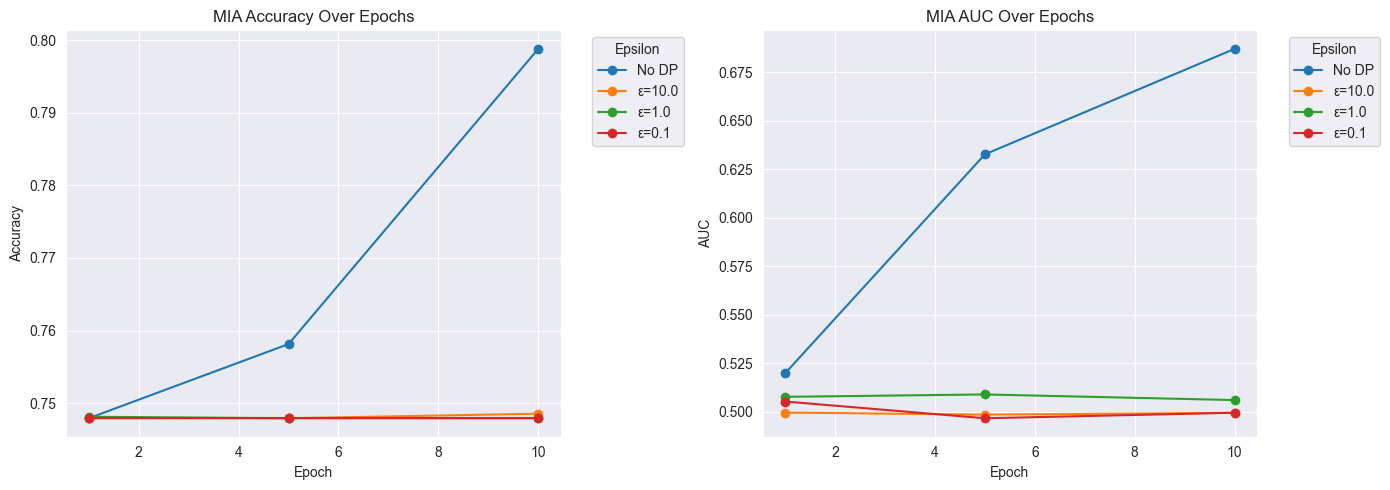

In [20]:
# Plot and analyze results
results_df, mia_results_df = plot_privacy_utility_tradeoff(results)
print("Performance Summary:")
display(results_df)

# MIA analysis
display(mia_results_df)
plot_mia_results(results)

In [21]:
# Save results
results_df.to_csv('performance_results.csv', index=False)
mia_results_df.to_csv('mia_results.csv', index=False)